#### Imports

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from keras import models
from keras import layers
import shap

# print the JS visualization code to the notebook
shap.initjs()

Using TensorFlow backend.


#### Data Loading

In [2]:
dataset = pd.read_csv('Clean_Form.csv')

In [3]:
dataset.head()

,Timestamp,Age,Gender,State,City Tier,Education Level,Employement Status,Product Category
0,6/10/2021 12:19:24,19,Male,Delhi,Tier 1,Bachelor Degree,Not Employed,"OTT Subscription (Example: Netflix, Amazon Pri..."
1,6/10/2021 12:20:45,20,Female,Delhi,Tier 1,Bachelor Degree,Not Employed,Medical supplies
2,6/10/2021 12:25:41,20,Male,Delhi,Tier 1,Bachelor Degree,Not Employed,"OTT Subscription (Example: Netflix, Amazon Pri..."
3,6/10/2021 12:26:17,20,Male,Delhi,Tier 1,Bachelor Degree,Not Employed,Clothing and accessories
4,6/10/2021 12:26:26,20,Male,Delhi,Tier 1,Bachelor Degree,Not Employed,Electronics


*Removing 'Timestamp' column as its not a valid feature*

In [4]:
dataset_clean = dataset.drop('Timestamp', axis=1)

In [5]:
dataset_clean.head()

,Age,Gender,State,City Tier,Education Level,Employement Status,Product Category
0,19,Male,Delhi,Tier 1,Bachelor Degree,Not Employed,"OTT Subscription (Example: Netflix, Amazon Pri..."
1,20,Female,Delhi,Tier 1,Bachelor Degree,Not Employed,Medical supplies
2,20,Male,Delhi,Tier 1,Bachelor Degree,Not Employed,"OTT Subscription (Example: Netflix, Amazon Pri..."
3,20,Male,Delhi,Tier 1,Bachelor Degree,Not Employed,Clothing and accessories
4,20,Male,Delhi,Tier 1,Bachelor Degree,Not Employed,Electronics


## Data Analysis

Most of the collected data if categorical data with only exception being 'Age'

In [6]:
dataset_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 224 non-null    int64 
 1   Gender              224 non-null    object
 2   State               224 non-null    object
 3   City Tier           224 non-null    object
 4   Education Level     224 non-null    object
 5   Employement Status  224 non-null    object
 6   Product Category    224 non-null    object
dtypes: int64(1), object(6)
memory usage: 12.4+ KB


In [7]:
# Creating the label decoding for _
product = dataset_clean['Product Category'].astype('category')
label_encoding_product = dict(enumerate(product.cat.categories))
print (label_encoding_product)

{0: 'Clothing and accessories', 1: 'Cosmetics', 2: 'Electronics', 3: 'Footwear', 4: 'Household', 5: 'Medical supplies', 6: 'OTT Subscription (Example: Netflix, Amazon Prime, etc.)', 7: 'Stationery'}


In [8]:
# Encoding the _ column through label decoding
dataset_clean["Product Category"] = dataset_clean["Product Category"].astype('category')
dataset_clean["Product Category"] = dataset_clean["Product Category"].cat.codes

## Exploratory Data Analysis

In [9]:
# Get list of categorical variables
s = (dataset_clean.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Gender', 'State', 'City Tier', 'Education Level', 'Employement Status']


In [10]:
# Make copy to avoid changing original data 
dataset_analysis = dataset_clean.copy()

# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for col in object_cols:
    dataset_analysis[col] = label_encoder.fit_transform(dataset_clean[col])

dataset_analysis.head()

,Age,Gender,State,City Tier,Education Level,Employement Status,Product Category
0,19,1,1,0,0,1,6
1,20,0,1,0,0,1,5
2,20,1,1,0,0,1,6
3,20,1,1,0,0,1,0
4,20,1,1,0,0,1,2


*Describe is used for calculating some statistical data like percentile, mean and std of the numerical values of the Series or DataFrame. The most important analysis here is of the age column as all other columns don't give us any useful information as they are Categorical data.*

Here we can see that Maximum age of responder is 82, while the mean value of the responders lie around 30 years

In [11]:
dataset_analysis.describe()

,Age,Gender,State,City Tier,Education Level,Employement Status,Product Category
count,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000
mean,30.084821,0.781250,4.093750,0.352679,0.848214,0.486607,2.571429
std,12.386053,0.414325,2.402382,0.610588,1.069008,0.500940,2.073598
min,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
50%,26.000000,1.000000,6.000000,0.000000,0.000000,0.000000,2.000000
75%,38.250000,1.000000,6.000000,1.000000,1.000000,1.000000,4.000000
max,82.000000,1.000000,8.000000,2.000000,3.000000,1.000000,7.000000


Here we can see that most of the respondent lie between 18-30 years while there is a good spread all around

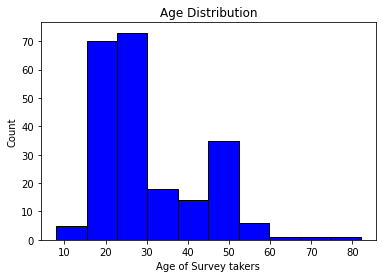

In [12]:
# Plotting a histogram of Age column
plt.hist(dataset_analysis['Age'], color='blue', edgecolor='black')
plt.xlabel('Age of Survey takers')
plt.ylabel('Count')
plt.title('Age Distribution');

Most of the responders were Male

In [13]:
# value_counts() function returns object containing counts of unique values
dataset_clean["Gender"].value_counts()

Male      175
Female     49
Name: Gender, dtype: int64

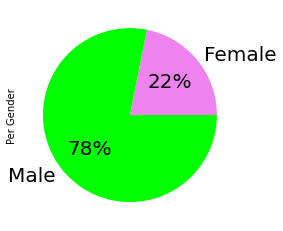

In [14]:
# Plotting a pie chart for Age column
dataset_clean.groupby('Gender').size().plot(kind='pie',
                                 autopct='%1.0f%%',
                                 textprops={'fontsize': 20},
                                 colors=['violet', 'lime'],
                                 ylabel= "Per Gender");

Most of the responders were from Tier 1 city while there was a good spread of responders from Tier 2 and Tier 3 citites.

In [15]:
dataset_clean["City Tier"].value_counts()

Tier 1    161
Tier 2     47
Tier 3     16
Name: City Tier, dtype: int64

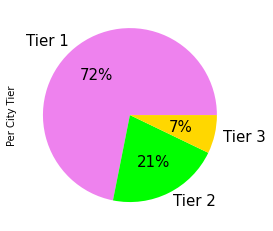

In [16]:
# Plotting a pie chart for Age column
dataset_clean.groupby('City Tier').size().plot(kind='pie',
                               autopct='%1.0f%%',
                               textprops={'fontsize': 15},
                               colors=['violet', 'lime', 'gold'],
                               ylabel= "Per City Tier");

Most of the responders were from 'Rajasthan' followed by 'Delhi' and 'Gujarat' respectively.

In [17]:
dataset_clean["State"].value_counts()

Rajasthan         114
Delhi              59
Gujarat            33
Uttar Pradesh       6
Uttarakhand         6
Haryana             3
Maharashtra         1
Bihar               1
Madhya Pradesh      1
Name: State, dtype: int64

In total there were 9 states from where responses were collected.

In [18]:
dataset_clean["State"].nunique()

9

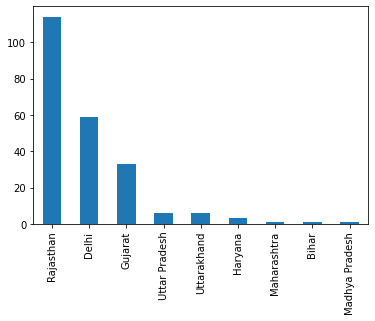

In [19]:
dataset_clean["State"].value_counts().plot(kind = "bar");

Most of the responders prefered 'Electronic' items followed by 'Clothing and accessories' and 'Household' respectively

In [20]:
dataset["Product Category"].value_counts()

Electronics                                                89
Clothing and accessories                                   50
Household                                                  30
OTT Subscription (Example: Netflix, Amazon Prime, etc.)    15
Medical supplies                                           15
Stationery                                                 13
Cosmetics                                                   7
Footwear                                                    5
Name: Product Category, dtype: int64

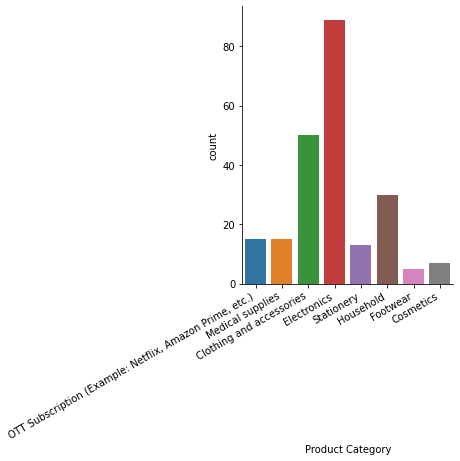

In [21]:
ax = sns.catplot(x='Product Category',kind='count',data= dataset,orient="h")
ax.fig.autofmt_xdate()

Here is a graph to see which age group preferred which Products.

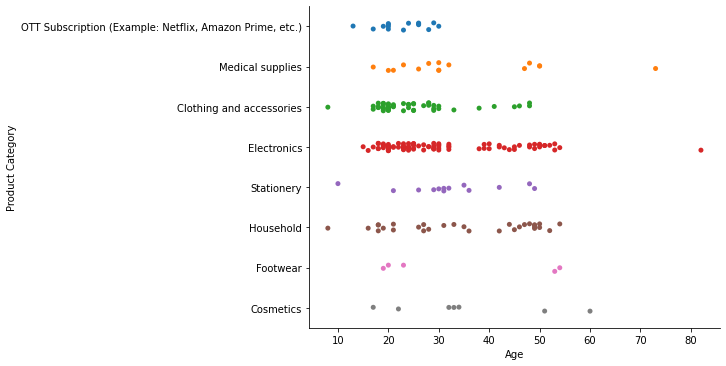

In [22]:
sns.catplot(x="Age",y="Product Category",data=dataset, aspect=2);

Further more I collected two additional pieces of information which I believed would increase the prediction capabilities. 
These were **Education Level** and **Employement Status**.
Using **Employement Status** allowed me to evaluate whether the responder has a constant source of income which would directly correlate with their purchasing power.
Using **Education Level** also affects their purchasing power as it can directly correlate to how much they might earn. Also since **Education Level** can be correlated with **Age** and thus it will also affect which type of products they might prefer.

Most of the responders have Bachelor Degree followed by Master Degree 

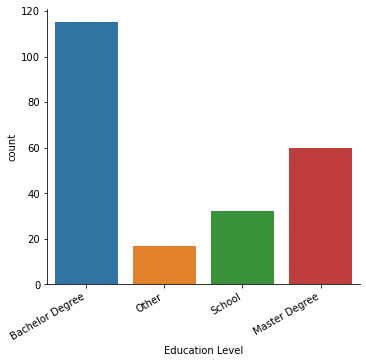

In [23]:
ax = sns.catplot(x='Education Level',kind='count',data= dataset,orient="h")
ax.fig.autofmt_xdate()

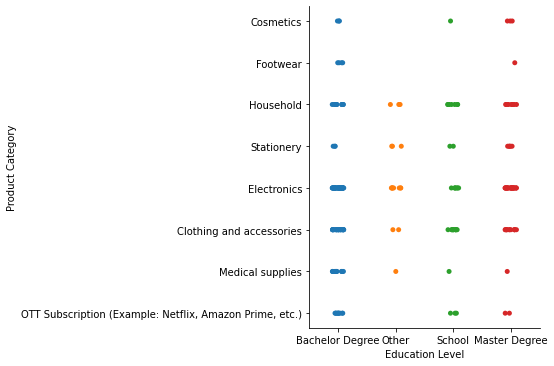

In [24]:
sns.catplot(x="Education Level",y="Product Category",data=dataset, aspect=1.5)

Most of the responders were 'Employed'

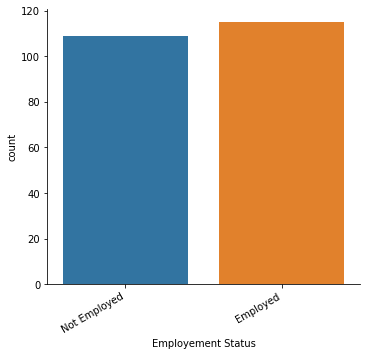

In [25]:
ax = sns.catplot(x='Employement Status',kind='count',data= dataset,orient="h")
ax.fig.autofmt_xdate()

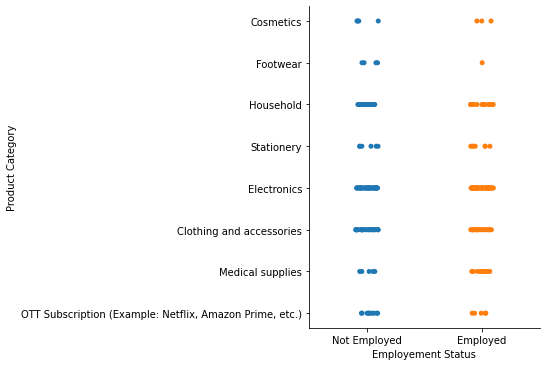

In [26]:
sns.catplot(x="Employement Status",y="Product Category",data=dataset, aspect=1.5)

## Feature Engineering
### Mutual Information

Mutual information describes relationships in terms of uncertainty. The mutual information (MI) between two quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other.

The least possible mutual information between quantities is 0.0. When MI is zero, the quantities are independent: neither can tell you anything about the other. Conversely, in theory there's no upper bound to what MI can be. In practice though values above 2.0 or so are uncommon.

In [27]:
plt.style.use("seaborn-whitegrid")

X = dataset_clean.copy()
y = X.pop("Product Category")

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

from sklearn.feature_selection import mutual_info_classif

def make_mi_scores(X, y):
    mi_scores = mutual_info_classif(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y)
mi_scores[::]  # show a few features with their MI scores

Age                   0.144864
Gender                0.118478
City Tier             0.049673
Employement Status    0.041361
State                 0.024639
Education Level       0.000000
Name: MI Scores, dtype: float64

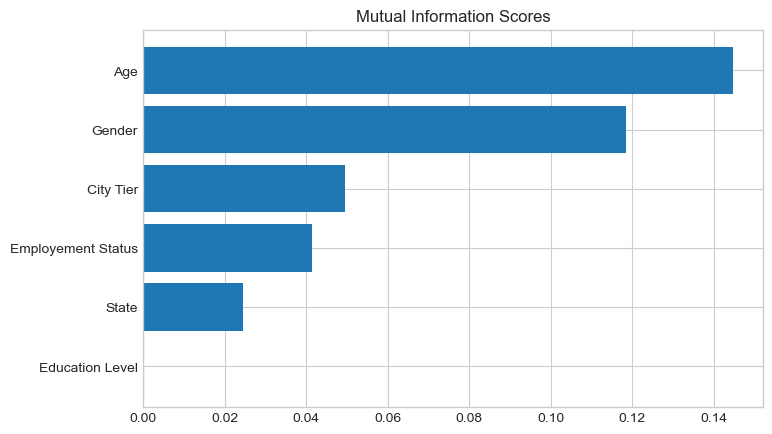

In [28]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

### Inference from Mutual Information
After running various instances of Mutual Information, it was observed that the following features were the most important features for predicting 'Product Category':
1. 'Gender' 
2. 'Age'
3. 'State'

Let's analyse what will actually happen.

# Model Building 

## Encoding

Encoding is the process of converting our categorical data into numeric data which the machine can understand and thus helping our model to generate effective rules for predicting the classses of our incoming data

### One-Hot Encoder

One-hot encoding creates new columns indicating the presence (or absence) of each possible value in the original data. After training with Label encoding and comparing its performance with One Hot Encoding, I came to the conclusion of using One Hot Encoding as it gave me the best possible performance.

In [29]:
s = (dataset_clean.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Gender', 'State', 'City Tier', 'Education Level', 'Employement Status']


In [30]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols = pd.DataFrame(OH_encoder.fit_transform(dataset_clean[object_cols]))
OH_cols.index = dataset_clean.index
num_data = dataset_clean.drop(object_cols, axis=1)
OH_data = pd.concat([num_data, OH_cols], axis=1)

In [31]:
OH_data.head()

,Age,Product Category,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
0,19,6,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,20,5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,20,6,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,20,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,20,2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [32]:
OH_features = OH_data.drop('Product Category', axis=1)

In [33]:
OH_features.head()

,Age,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,19,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,20,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,20,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,20,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,20,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [34]:
OH_label = OH_data['Product Category']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(OH_features, OH_label, test_size=0.25, random_state=42)

In [36]:
model_one_hot = models.Sequential()
model_one_hot.add(layers.Dense(64, activation='relu', input_shape=(21,)))
model_one_hot.add(layers.Dense(64, activation='relu'))
model_one_hot.add(layers.Dense(64, activation='relu'))
model_one_hot.add(layers.Dense(8, activation='softmax'))

model_one_hot.compile(optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])

In [37]:
model_one_hot.fit(X_train,
y_train,
epochs=150,
batch_size=32,
validation_split=0.2)

Train on 134 samples, validate on 34 samples
Epoch 1/150
134/134 [==============================] - 0s 2ms/step - loss: 2.0751 - accuracy: 0.3209 - val_loss: 1.7094 - val_accuracy: 0.5000
Epoch 2/150
134/134 [==============================] - 0s 90us/step - loss: 1.8719 - accuracy: 0.3284 - val_loss: 1.7592 - val_accuracy: 0.4706
Epoch 3/150
134/134 [==============================] - 0s 90us/step - loss: 1.8856 - accuracy: 0.3582 - val_loss: 1.6913 - val_accuracy: 0.4118
Epoch 4/150
134/134 [==============================] - 0s 97us/step - loss: 1.8832 - accuracy: 0.3731 - val_loss: 1.6802 - val_accuracy: 0.4118
Epoch 5/150
134/134 [==============================] - 0s 97us/step - loss: 1.8343 - accuracy: 0.3731 - val_loss: 1.7126 - val_accuracy: 0.5294
Epoch 6/150
134/134 [==============================] - 0s 90us/step - loss: 1.8248 - accuracy: 0.3881 - val_loss: 1.7341 - val_accuracy: 0.4118
Epoch 7/150
134/134 [==============================] - 0s 97us/step - loss: 1.7967 - accurac

In [38]:
model_one_hot.evaluate(X_test, y_test, batch_size=32)

56/56 [==============================] - 0s 54us/step


[1.4643103906086512, 0.6428571343421936]

**Final Accuracy on Test Set: 0.64**

### Age Binning
The 'Age' column in our dataset is a continuous value with a very long spread that might hinder the model to extract useful information from it and thus I created bins of ages thus reducing the variance of age and allowing the model to focus upon extracting useful information.

In [39]:
dataset_age_binning = dataset_clean.copy()

In [40]:
dataset_age_binning

,Age,Gender,State,City Tier,Education Level,Employement Status,Product Category
0,19,Male,Delhi,Tier 1,Bachelor Degree,Not Employed,6
1,20,Female,Delhi,Tier 1,Bachelor Degree,Not Employed,5
2,20,Male,Delhi,Tier 1,Bachelor Degree,Not Employed,6
3,20,Male,Delhi,Tier 1,Bachelor Degree,Not Employed,0
4,20,Male,Delhi,Tier 1,Bachelor Degree,Not Employed,2
...,...,...,...,...,...,...,...
219,28,Female,Delhi,Tier 1,Master Degree,Employed,0
220,26,Male,Delhi,Tier 1,Master Degree,Employed,7
221,24,Male,Delhi,Tier 1,Bachelor Degree,Employed,2
222,23,Male,Delhi,Tier 1,Bachelor Degree,Employed,2


In [41]:
cut_labels = ['Teens', "20's", "30's", "40's", "50's", "60's", "70's", "80's", "90's", "100's"]

# Define bin edges
cut_bins = np.arange(10, 111, 10)

# Create a new column grouping birth_year into generations
dataset_age_binning['Bin_Age'] = pd.cut(dataset_age_binning['Age'], bins=cut_bins, labels=cut_labels)

In [42]:
dataset_age_binning = dataset_age_binning.drop('Age', axis=1)
dataset_age_binning.head()

,Gender,State,City Tier,Education Level,Employement Status,Product Category,Bin_Age
0,Male,Delhi,Tier 1,Bachelor Degree,Not Employed,6,Teens
1,Female,Delhi,Tier 1,Bachelor Degree,Not Employed,5,Teens
2,Male,Delhi,Tier 1,Bachelor Degree,Not Employed,6,Teens
3,Male,Delhi,Tier 1,Bachelor Degree,Not Employed,0,Teens
4,Male,Delhi,Tier 1,Bachelor Degree,Not Employed,2,Teens


In [43]:
categorical_features = ['Gender', 'State', 'City Tier', 'Education Level', 'Employement Status', 'Bin_Age']
for col in categorical_features:
    dummies = pd.get_dummies(dataset_age_binning[col], prefix=col)
    dataset_age_binning = pd.concat([dataset_age_binning, dummies], axis=1)
    dataset_age_binning.drop(col, axis=1, inplace=True)

In [44]:
X_age_bin = dataset_age_binning.copy()
y_age_bin = X_age_bin.pop('Product Category')

In [45]:
X_age_bin_train, X_age_bin_test, y_age_bin_train, y_age_bin_test = train_test_split(X_age_bin, y_age_bin, test_size=0.25, random_state=42)

In [46]:
model_bin = models.Sequential()
model_bin.add(layers.Dense(64, activation='relu', input_shape=(30,)))
model_bin.add(layers.Dense(64, activation='relu'))
model_bin.add(layers.Dense(64, activation='relu'))
model_bin.add(layers.Dense(8, activation='softmax'))

In [47]:
model_bin.compile(optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])

In [48]:
model_bin.fit(X_age_bin_train,
y_age_bin_train,
epochs=150,
batch_size=32,
validation_split=0.2)

Train on 134 samples, validate on 34 samples
Epoch 1/150
134/134 [==============================] - 0s 792us/step - loss: 2.1095 - accuracy: 0.1194 - val_loss: 2.0491 - val_accuracy: 0.1176
Epoch 2/150
134/134 [==============================] - 0s 90us/step - loss: 2.0204 - accuracy: 0.1493 - val_loss: 1.9572 - val_accuracy: 0.1765
Epoch 3/150
134/134 [==============================] - 0s 97us/step - loss: 1.9480 - accuracy: 0.2612 - val_loss: 1.8736 - val_accuracy: 0.4118
Epoch 4/150
134/134 [==============================] - 0s 97us/step - loss: 1.8786 - accuracy: 0.4030 - val_loss: 1.7929 - val_accuracy: 0.4412
Epoch 5/150
134/134 [==============================] - 0s 97us/step - loss: 1.8138 - accuracy: 0.3955 - val_loss: 1.7185 - val_accuracy: 0.4412
Epoch 6/150
134/134 [==============================] - 0s 112us/step - loss: 1.7559 - accuracy: 0.3955 - val_loss: 1.6522 - val_accuracy: 0.4118
Epoch 7/150
134/134 [==============================] - 0s 97us/step - loss: 1.7134 - accu

In [49]:
model_bin.evaluate(X_age_bin_test, y_age_bin_test, batch_size=32)

56/56 [==============================] - 0s 36us/step


[2.0216665949140276, 0.5357142686843872]

## Final Analysis

As can be seen Age binning didn't help with our accuracy (0.53).

### By only using 'Gender', 'State', 'City Tier' and 'Age'

Comparing the performance of the same model only on three original features specified namely: **Gender**, **State** ,**City Tier** and **Age**. Thus seeing with our initial analysis on how much these features alone are useful.

In [50]:
dataset_3 = dataset_clean.copy()
dataset_3 = dataset_3.drop(['Education Level', 'Employement Status'], axis=1)
dataset_3.head()

,Age,Gender,State,City Tier,Product Category
0,19,Male,Delhi,Tier 1,6
1,20,Female,Delhi,Tier 1,5
2,20,Male,Delhi,Tier 1,6
3,20,Male,Delhi,Tier 1,0
4,20,Male,Delhi,Tier 1,2


In [51]:
s = (dataset_3.dtypes == 'object')
object_cols3 = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Gender', 'State', 'City Tier', 'Education Level', 'Employement Status']


In [52]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_3 = pd.DataFrame(OH_encoder.fit_transform(dataset_3[object_cols3]))
OH_cols_3.index = dataset_3.index
num_X3 = dataset_3.drop(object_cols3, axis=1)
OH_X3 = pd.concat([num_X3, OH_cols_3], axis=1)

In [53]:
OH_X3

,Age,Product Category,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,19,6,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,20,5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,20,6,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,20,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,20,2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,28,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
220,26,7,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
221,24,2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
222,23,2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [54]:
X3 = OH_X3.drop('Product Category', axis=1)
y3 = OH_X3['Product Category']
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.25, random_state=42)

In [55]:
model3 = models.Sequential()
model3.add(layers.Dense(64, activation='relu', input_shape=(15,)))
model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dense(8, activation='softmax'))

model3.compile(optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])

In [56]:
model3.fit(X_train3,
y_train3,
epochs=150,
batch_size=32,
validation_split=0.2)

Train on 134 samples, validate on 34 samples
Epoch 1/150
134/134 [==============================] - 0s 796us/step - loss: 3.2319 - accuracy: 0.0448 - val_loss: 2.2752 - val_accuracy: 0.4118
Epoch 2/150
134/134 [==============================] - 0s 97us/step - loss: 2.4242 - accuracy: 0.3731 - val_loss: 2.0021 - val_accuracy: 0.4118
Epoch 3/150
134/134 [==============================] - 0s 90us/step - loss: 2.0997 - accuracy: 0.3731 - val_loss: 1.8926 - val_accuracy: 0.4706
Epoch 4/150
134/134 [==============================] - 0s 90us/step - loss: 1.9622 - accuracy: 0.2836 - val_loss: 1.7688 - val_accuracy: 0.4412
Epoch 5/150
134/134 [==============================] - 0s 97us/step - loss: 1.8449 - accuracy: 0.3806 - val_loss: 1.6832 - val_accuracy: 0.4118
Epoch 6/150
134/134 [==============================] - 0s 97us/step - loss: 1.8111 - accuracy: 0.3731 - val_loss: 1.6787 - val_accuracy: 0.4118
Epoch 7/150
134/134 [==============================] - 0s 97us/step - loss: 1.8647 - accur

In [57]:
model3.evaluate(X_test3, y_test3, batch_size=32)

56/56 [==============================] - 0s 54us/step


[1.434187344142369, 0.5714285969734192]

### Inference

So our initial inference was wrong as considering the 3 most important faeture from MI didn't give fruitful result.

### By including Employement Status column and analyzing it's importance

In [58]:
dataset_emp = dataset_clean.copy()
dataset_emp = dataset_emp.drop('Education Level', axis=1)
dataset_emp

,Age,Gender,State,City Tier,Employement Status,Product Category
0,19,Male,Delhi,Tier 1,Not Employed,6
1,20,Female,Delhi,Tier 1,Not Employed,5
2,20,Male,Delhi,Tier 1,Not Employed,6
3,20,Male,Delhi,Tier 1,Not Employed,0
4,20,Male,Delhi,Tier 1,Not Employed,2
...,...,...,...,...,...,...
219,28,Female,Delhi,Tier 1,Employed,0
220,26,Male,Delhi,Tier 1,Employed,7
221,24,Male,Delhi,Tier 1,Employed,2
222,23,Male,Delhi,Tier 1,Employed,2


In [59]:
s = (dataset_emp.dtypes == 'object')
object_cols_emp = list(s[s].index)

print("Categorical variables:")
print(object_cols_emp)

Categorical variables:
['Gender', 'State', 'City Tier', 'Employement Status']


In [60]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_emp = pd.DataFrame(OH_encoder.fit_transform(dataset_emp[object_cols_emp]))
OH_cols_emp.index = dataset_emp.index
num_X_emp = dataset_emp.drop(object_cols_emp, axis=1)
OH_X_emp = pd.concat([num_X_emp, OH_cols_emp], axis=1)

In [61]:
X_emp = OH_X_emp.drop('Product Category', axis=1)
y_emp = OH_X_emp['Product Category']

In [62]:
X_train_emp, X_test_emp, y_train_emp, y_test_emp = train_test_split(X_emp, y_emp, test_size=0.25, random_state=42)

In [63]:
model_emp = models.Sequential()
model_emp.add(layers.Dense(64, activation='relu', input_shape=(17,)))
model_emp.add(layers.Dense(64, activation='relu'))
model_emp.add(layers.Dense(64, activation='relu'))
model_emp.add(layers.Dense(8, activation='softmax'))

model_emp.compile(optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])

In [64]:
model_emp.fit(X_train_emp,
y_train_emp,
epochs=150,
batch_size=32,
validation_split=0.2)

Train on 134 samples, validate on 34 samples
Epoch 1/150
134/134 [==============================] - 0s 792us/step - loss: 2.2160 - accuracy: 0.2015 - val_loss: 1.7115 - val_accuracy: 0.4118
Epoch 2/150
134/134 [==============================] - 0s 97us/step - loss: 1.8858 - accuracy: 0.2537 - val_loss: 1.8183 - val_accuracy: 0.1765
Epoch 3/150
134/134 [==============================] - 0s 105us/step - loss: 1.8984 - accuracy: 0.1642 - val_loss: 1.7218 - val_accuracy: 0.4118
Epoch 4/150
134/134 [==============================] - 0s 90us/step - loss: 1.8267 - accuracy: 0.3731 - val_loss: 1.6746 - val_accuracy: 0.4118
Epoch 5/150
134/134 [==============================] - 0s 105us/step - loss: 1.8172 - accuracy: 0.3731 - val_loss: 1.6925 - val_accuracy: 0.4118
Epoch 6/150
134/134 [==============================] - 0s 97us/step - loss: 1.7889 - accuracy: 0.3731 - val_loss: 1.6709 - val_accuracy: 0.4118
Epoch 7/150
134/134 [==============================] - 0s 97us/step - loss: 1.7815 - acc

In [65]:
model_emp.evaluate(X_test_emp, y_test_emp, batch_size=32)

56/56 [==============================] - 0s 54us/step


[1.4233082362583704, 0.5892857313156128]

### Inference

Including Employement Status slighlty increased our accuracy.

### By including Education Level column and analyzing it's importance

In [66]:
dataset_edu = dataset_clean.copy()
dataset_edu = dataset_edu.drop('Employement Status', axis=1)
dataset_edu

,Age,Gender,State,City Tier,Education Level,Product Category
0,19,Male,Delhi,Tier 1,Bachelor Degree,6
1,20,Female,Delhi,Tier 1,Bachelor Degree,5
2,20,Male,Delhi,Tier 1,Bachelor Degree,6
3,20,Male,Delhi,Tier 1,Bachelor Degree,0
4,20,Male,Delhi,Tier 1,Bachelor Degree,2
...,...,...,...,...,...,...
219,28,Female,Delhi,Tier 1,Master Degree,0
220,26,Male,Delhi,Tier 1,Master Degree,7
221,24,Male,Delhi,Tier 1,Bachelor Degree,2
222,23,Male,Delhi,Tier 1,Bachelor Degree,2


In [67]:
s = (dataset_edu.dtypes == 'object')
object_cols_edu = list(s[s].index)

print("Categorical variables:")
print(object_cols_edu)

Categorical variables:
['Gender', 'State', 'City Tier', 'Education Level']


In [68]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_edu = pd.DataFrame(OH_encoder.fit_transform(dataset_edu[object_cols_edu]))
OH_cols_edu.index = dataset_edu.index
num_X_edu = dataset_edu.drop(object_cols_edu, axis=1)
OH_X_edu = pd.concat([num_X_edu, OH_cols_edu], axis=1)

In [69]:
X_edu = OH_X_edu.drop('Product Category', axis=1)
y_edu = OH_X_edu['Product Category']
X_train_edu, X_test_edu, y_train_edu, y_test_edu = train_test_split(X_edu, y_edu, test_size=0.25, random_state=42)

In [70]:
model_edu = models.Sequential()
model_edu.add(layers.Dense(64, activation='relu', input_shape=(19,)))
model_edu.add(layers.Dense(64, activation='relu'))
model_edu.add(layers.Dense(64, activation='relu'))
model_edu.add(layers.Dense(8, activation='softmax'))

model_edu.compile(optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])

In [71]:
model_edu.fit(X_train_edu,
y_train_edu,
epochs=150,
batch_size=32,
validation_split=0.2)

Train on 134 samples, validate on 34 samples
Epoch 1/150
134/134 [==============================] - 0s 784us/step - loss: 2.4788 - accuracy: 0.3358 - val_loss: 1.9487 - val_accuracy: 0.3529
Epoch 2/150
134/134 [==============================] - 0s 82us/step - loss: 2.0509 - accuracy: 0.3582 - val_loss: 1.7329 - val_accuracy: 0.4118
Epoch 3/150
134/134 [==============================] - 0s 105us/step - loss: 1.8693 - accuracy: 0.3731 - val_loss: 1.7716 - val_accuracy: 0.4118
Epoch 4/150
134/134 [==============================] - 0s 97us/step - loss: 1.8456 - accuracy: 0.3433 - val_loss: 1.8028 - val_accuracy: 0.2647
Epoch 5/150
134/134 [==============================] - 0s 105us/step - loss: 1.8357 - accuracy: 0.3134 - val_loss: 1.6969 - val_accuracy: 0.4118
Epoch 6/150
134/134 [==============================] - 0s 90us/step - loss: 1.8171 - accuracy: 0.3731 - val_loss: 1.6648 - val_accuracy: 0.4118
Epoch 7/150
134/134 [==============================] - 0s 105us/step - loss: 1.8042 - ac

In [72]:
model_edu.evaluate(X_test_edu, y_test_edu, batch_size=32)

56/56 [==============================] - 0s 36us/step


[1.5588150535311018, 0.6071428656578064]

### Inference

Major boost in accuracy was given by including Education level as our features.

# Machine Explainability

Analysing what the model actually considers the most and least important features.

## SHAP Values

SHAP Values (an acronym from SHapley Additive exPlanations) break down a prediction to show the impact of each feature.
SHAP values interpret the impact of having a certain value for a given feature in comparison to the prediction we'd make if that feature took some baseline value.

In [73]:
X_train.iloc[:1,:]

,Age,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
100,22,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [74]:
def f(X):
    return model_one_hot.predict_classes([X])

In [77]:
explainer = shap.KernelExplainer(f, X_train.iloc[:1,:])
shap_values = explainer.shap_values(X_train.iloc[42,:], nsamples=100)
shap.force_plot(explainer.expected_value, shap_values, X_train.iloc[42,:])

## Inference from SHAP Values

Age is considered the most important feature by our model, followed by One-Hot Encoding Labels '1'-0, '19'-1 and '18'-0.
Least important feature according to our model were, '3'-1 and '0'-1.

# FINAL INFERENCE

By including both **Employement Status** and **Education Level** it was observed that accuracy of our model on test data was significantly improved but most important feature according to my analysis was **Education Level**.

But to come an actual conclusion on this low dataset with little spread wouldn't be right and thus further analysis is required on bigger dataset with more features.